PROSSIMI STEPS¶
analizzare e creare distribuzioni dei falsi negativi e falsi positivi per farlo dobbiamo estrarre le posizioni delle proteine false negative e false positive utilizzando i target vector e predicted vector si può fare con la funzione zip: if observed == 0 e target == 1: allora false_negative.append(indice di quella proteina) if observed == 1 e target == 0: allora false_positive.append(indice di quella proteina) poi avendo gli index (che corrispondono a posizioni di righe nel dataframe del benchmark) possiamo creare due nuovi dataframe ee creare delle distribuzioni

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import matthews_corrcoef , confusion_matrix

 # Von Heijine PERFORMANCE

In [2]:
#!pip install importnb
import sys
from importnb import Notebook

# add the folder vonheijine that contains our vonheijine functions
sys.path.append("../vonHeijne/")

# import the notebook that contains the pswm creator and the testing of vonheijine
with Notebook():
    import create_pswm, validation_and_testing_vonheijne


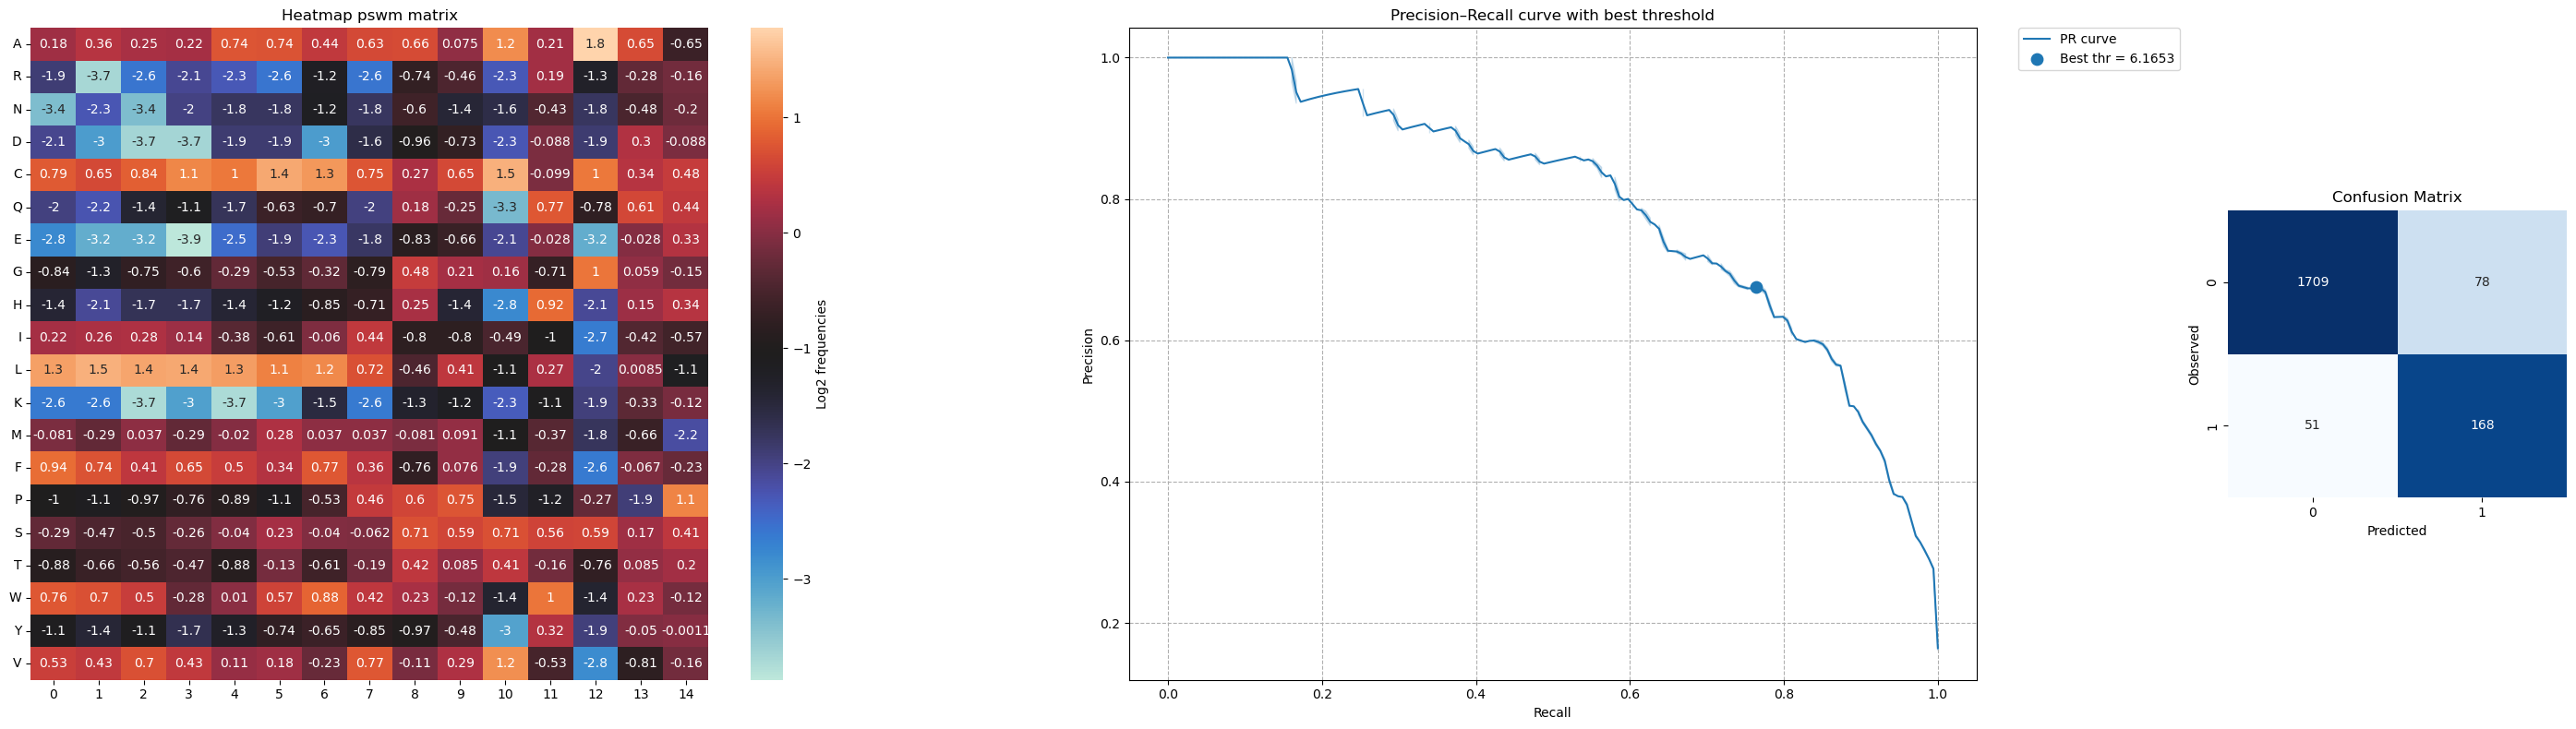

In [19]:
dataset = pd.read_csv("../Data_Preparation/train_bench.tsv", sep = "\t")
pswm=create_pswm.get_pswm(dataset.query("(Set=='1' or Set=='5' or Set=='3' or Set=='4') and Class=='Positive'"), 13,2)

stats=validation_and_testing_vonheijne.metrics(pswm, dataset.query("(Set=='2')") , dataset.query("Set=='Benchmark'"))

In [20]:
metrics_name = ["MCC", "Precision", "Accuracy", "Sensitivity" , "Confusion Matrix"]
for name, stat in zip(metrics_name,stats): 
    if name=="Confusion Matrix":
        confusion_df = pd.DataFrame(stat, columns=["Positive" , "Negative"], index=["Positive", "Negative"])
        print(f"{name} : \n{confusion_df}")
    else:    
        print(f"{name} = {stat}")

MCC = 0.6878342596948499
Precision = 0.9356929212362911
Accuracy = 0.6829268292682927
Sensitivity = 0.7671232876712328
Confusion Matrix : 
          Positive  Negative
Positive      1709        78
Negative        51       168


# SVM PERFORMANCE

In [21]:
#create the pipeline
pipeline = Pipeline([("scaler" , StandardScaler()) , ("svm" , SVC())])
# load training
loaded_data_train = np.load('training_features.npz')
x_train = loaded_data_train['matrix']
y_train = loaded_data_train['target']

# load testing
loaded_data_test = np.load('benchmark_features.npz')
x_test = loaded_data_test['matrix']
y_test = loaded_data_test['target']

#set the optimal parameters and train the model on train data
final_classifier = pipeline.set_params(svm__C=10, svm__gamma=0.029917234770138655  ,svm__kernel="rbf").fit(x_train, y_train)
#predict the benchmark set
bench_pred = final_classifier.predict(x_test)

In [6]:
svm_fp = []
svm_fn = []
#create lists of indexes of the false positive and false negative proteins
for i in range(len(y_test)):
    if bench_pred[i] == 0 and y_test[i] == 1:
        svm_fn.append(i)
    elif bench_pred[i] == 1 and y_test[i] == 0:
        svm_fp.append(i)
    else:
        pass

([<matplotlib.axis.YTick at 0x76669f7fad50>,
 [Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')])

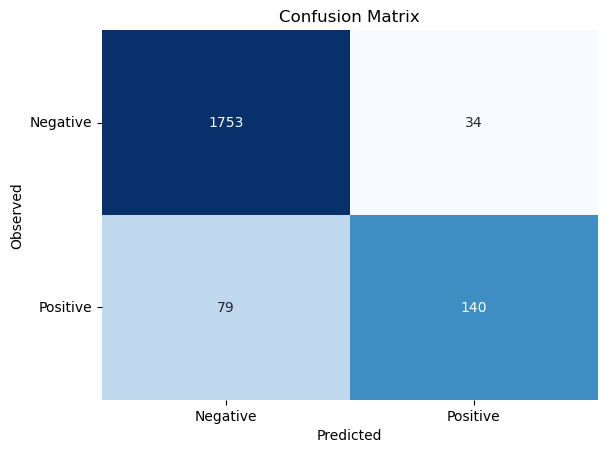

In [22]:
conf_mat = confusion_matrix( y_test, bench_pred)
sns.heatmap(
        conf_mat,
        annot=True,
        cmap="Blues",
        fmt="d",
        cbar=False,
        vmax = 200      
    )
plt.xlabel("Predicted")
plt.ylabel("Observed")  
plt.title("Confusion Matrix")  
plt.xticks(ticks=[0.5, 1.5], labels=["Negative", "Positive"])
plt.yticks(ticks=[0.5, 1.5], labels=["Negative", "Positive"], rotation=0)

In [23]:
# now import the dataset and create dataframes that only contain data of interest
benchmark=dataset.query("Set=='Benchmark'")
false_positives_df = benchmark.iloc[svm_fp]
false_negatives_df = benchmark.iloc[svm_fn]
true_positives_df = benchmark.query("Class == 'Positive'")
true_negatives_df = benchmark.query("Class == 'Negative'")
# create a new column in the benchmark dataframe to store information about classification
rows = benchmark.shape[0]
classification_col = []
for i in range(rows):
    if i in svm_fp:
        classification_col.append("FP")
        continue
    elif i in svm_fn:
        classification_col.append("FN")
        continue
    elif benchmark.iloc[i]["Class"] == "Negative":
        classification_col.append("TN")
    elif benchmark.iloc[i]["Class"] == "Positive":
        classification_col.append("TP")
benchmark["Prediction"]=classification_col

/tmp/ipykernel_1556/3743291469.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark["Prediction"]=classification_col


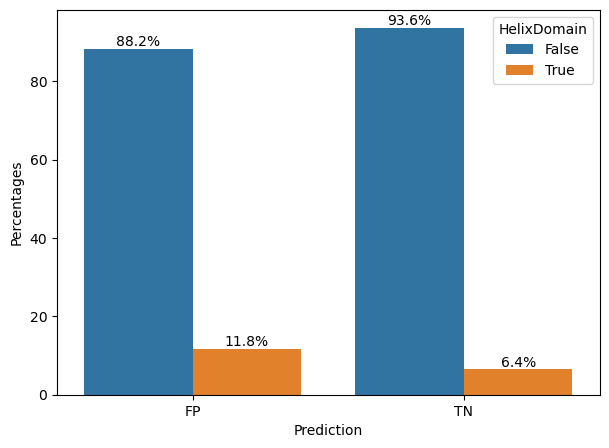

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# make counts in function of prediction and helix domain presence
counts = (
    benchmark
    .groupby(["Prediction", "HelixDomain"])
    .size()
    .rename("n")
    .reset_index()
)

# compute percentage within each prediction group relative to its own size
counts["percent"] = counts.groupby("Prediction")["n"].transform(lambda s: ( s / s.sum())*100)

# plot the histogram
plt.figure(figsize=(7,5))
ax = sns.barplot(data=counts, x="Prediction", y="percent", hue="HelixDomain")
ax.set_ylabel("Percentages")
ax.set_xlabel("Prediction")
ax.legend(title="HelixDomain")
for c in ax.containers:
    ax.bar_label(c, fmt="%.1f%%")
plt.show()


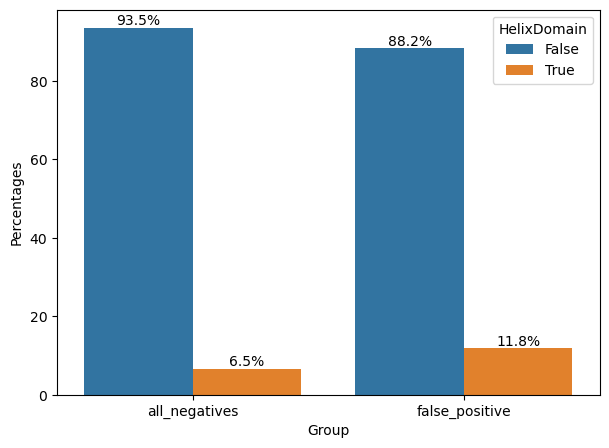

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# create the subset with all negatives (fp+tn) and a version with only the fp

all_negatives=benchmark.query("Class=='Negative'").copy()
all_negatives['Group']="all_negatives" #change this to change the label on the x-axis
false_positive=benchmark.query("Prediction=='FP'").copy()
false_positive['Group']="false_positive" #change this to change the label on the x-axis
counts_group=pd.concat([false_positive,all_negatives], ignore_index=True)

# make counts in function of group and helix domain presence
counts = (
    counts_group
    .groupby(["Group", "HelixDomain"])
    .size()
    .rename("n")
    .reset_index()
)
# compute percentage within fp group and total negatives relative to its own size
counts["percent"] = counts.groupby("Group")["n"].transform(lambda s: ( s / s.sum())*100)

# make the plot
plt.figure(figsize=(7,5))
ax = sns.barplot(data=counts, x="Group", y="percent", hue="HelixDomain")
ax.set_ylabel("Percentages")
ax.set_xlabel("Group")
ax.legend(title="HelixDomain")
for c in ax.containers:
    ax.bar_label(c, fmt="%.1f%%")
plt.show()